<div style="text-align:right">Peter Norvig<br>21 March 2018</div>

# `xkcd` Name Dominoes

![](https://norvig.com/xkcd-dominoes.png)

The March 21, 2018 `xkcd` comic (#1970) was **[Name Dominoes](https://xkcd.com/1970/)**: tiles laid out as if in a game of dominoes, but the tiles contain names of famous people. 
In regular [dominoes](https://en.wikipedia.org/wiki/Dominoes) a tile consists of two squares, each with a number of spots from 0 to 6. In xkcd name dominoes, the tiles can be one, two, or three squares in length, and each square contains a name (first, middle, or last). In both versions, a tile can be placed if it is adjacent to another tile on the board, and if no two adjacent squares contain different numbers/names.
I will write a function, `place_tiles`, to lay out name dominoes according to these rules. 

# Key Data Structures:

- **`Tile`**: a tile is a tuple of names, like `('ISSAC', 'NEWTON')`
or `('FRANK', 'LLOYD', 'WRIGHT')` or `('DRAKE',)`.
- **`Name`**: a name (first, middle, or last) is a string, like `'FRANK'`.
- **`Box`**: a structure with a tile, the square that the tile's first name goes on, and the direction in which to move to place subsequent names.
- **`Point`**: an `(x, y)` pair denoting the coordinates of a square on the board. Can also be used for **directions**: `(0, 1)` is the direction that goes 0 in the x axis and 1 in the y axis; also known as "up" or "90 degrees".
- **`Board`**: a [width × height] grid of squares, where each square can be filled with a name.  `Board` is implemented as a subclass of `dict` of the form `{(0, 0): 'ISSAC', (0, 1): 'NEWTON', ...}`, but with additional attributes to keep track of the width and height, and the boxes placed so far. If an `(x, y)` square is not in the dict, it is `empty` by default, unless the `(x, y)` coordinates are out of bounds; then it is `off` the board.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from collections import namedtuple

In [2]:
Tile  = tuple # e.g., ('ISSAC', 'NEWTON')
Name  = str   # e.g., 'ISSAC'
Box   = namedtuple('Box', 'start, dir, tile')

Point = tuple
def X(point) -> int: "The x coordinate of a point"; return point[0]
def Y(point) -> int: "The x coordinate of a point"; return point[1]

directions = {(1, 0): 0, (0, 1): 90, (-1, 0): 180, (0, -1): 270}

off   = '.'   # A square that is off the edge of the board
empty = ''    # An empty square (does not have a tile covering it)

class Board(dict):
    """A mapping from (x, y) squares to names; for a width x height board."""
    def __init__(self, width, height): 
        """Keep track of the width and height, and of boxes that have been placed."""
        self.width  = width 
        self.height = height
        self.boxes  = []
        
    def __missing__(self, square: Point) -> str: 
        """The contents of a filled square is a name; a missing square is empty or off."""
        return empty if (0 <= X(square) < self.width and 0 <= Y(square) < self.height) else off

# Algorithm to Fill the Board

Now I need a strategy to fill the board with tiles.  I will place tiles one at a time, and to make things easier I will *never* consider removing a tile from the board and backtracking. The major functions are:


- **`place_tiles(tiles)`**: The top-level strategy. Makes a board and places tiles on it, one at a time, until no more can be placed. Chooses a random tile for the first tile, then repeatedly calls `try_one_square` to legally place an additional tile on a square from the frontier, stopping when either there is no `frontier` left or no `tiles` left.
- **`frontier`**: I'll maintain a *frontier*, a set of `(x, y)` squares that are adjacent to tiles on the board, and thus are candidates for placing new tiles.
- **`try_one_square(tiles, board, frontier)`**: pop a square off the frontier, and try to find some tile that can legally put one of its names there; when found, `put_tile` the tile there, and remove it from `tiles`.
- **`can_put_tile(tile, board, start, dir)`**: Can we put this tile on the board at this start square, going in this direction?
- **`can_put_name(name, board, square)`**: Can this one name (first, middle, or last) be placed on this square?
- **`allowed(name, nbr_contents)`**: Is this name allowed to be placed next to this neighboring square's contents?
- **`neighbors(square, board)`**: returns the four neighbors of a square.
- **`put_tile(tile, board, start, dir, tiles, frontier)`**: places a tile on the board starting at `start` and going in direction `dir`; update the `frontier` to say that the just-covered squares are not in the frontier, but the empty neighbors of new tiles are. Remove the tile from `tiles`.
- **`move(start, steps, dir)`**: Returm the square that results from starting at `start` and going `steps` in 
direction  `dir`.

In [3]:
def place_tiles(tiles, width=16, height=35) -> Board:
    """Place as many tiles on board as possible."""
    tiles    = list(tiles); random.shuffle(tiles)
    board    = Board(width, height)
    frontier = set()
    put_tile(tiles[0], board, (width//2, height//2), (0, 1), tiles, frontier)
    while tiles and frontier:
        try_one_square(tiles, board, frontier) 
    return board

def try_one_square(tiles, board, frontier):
    """Pop a frontier square, and try to place a tile on that square."""
    square = frontier.pop()
    for tile in tiles:
        # The offset is used to shift the tile along `direction`
        for offset in range(len(tile)):
            for dir in directions:
                start = move(square, -offset, dir)
                if can_put_tile(tile, board, start, dir):
                    return put_tile(tile, board, start, dir, tiles, frontier)
                
def can_put_tile(tile, board, start, dir) -> bool:
    """Is it legal to put this tile on this square/direction on board?"""
    return all(can_put_name(name, board, move(start, i, dir))
               for i, name in enumerate(tile))

def can_put_name(name, board, square) -> bool:
    return (board[square] is empty 
            and all(allowed(name, board[nbr])
                    for nbr in neighbors(square, board)))

def allowed(name, nbr_contents) -> bool: return nbr_contents in (name, empty, off)

def neighbors(square, board) -> list:
    """Neighbors of this square on the board."""
    x, y = square
    return [(x+dx, y+dy) for (dx, dy) in directions]

def put_tile(tile, board, start, dir, tiles, frontier): 
    """Place the tile on the board at the start square, going in the given direction. 
    Update tiles and frontier."""
    board.boxes.append(Box(start, dir, tile))
    tiles.remove(tile)
    for i, name in enumerate(tile):
        square = move(start, i, dir)
        board[square] = name
        frontier -= {square}
        frontier |= {L for L in neighbors(square, board) if board[L] is empty}
        
def move(start: Point, steps: int, dir: Point) -> Point: 
    """Starting at `start` square, move a number of `steps` in direction `dir`."""
    return (X(start) + steps * X(dir),
            Y(start) + steps * Y(dir))

# Small Example

Here I create a small example with 8 tiles, and try to fill a board. You can see the boxes that were placed, and the names that are in each square:

In [4]:
tiles8 = [('JAMES', 'EARL', 'JONES'), ('QUINCY', 'JONES'), ('QUINCY', 'ADAMS'),  ('JOHN', 'ADAMS'), 
          ('JOHN', 'QUINCY', 'ADAMS'), ('HENRY', 'JAMES'),  ('JOHN', 'HENRY'), ('EARL',)]

board = place_tiles(tiles8, 7, 7)

In [5]:
board.boxes

[Box(start=(3, 3), dir=(0, 1), tile=('QUINCY', 'ADAMS')),
 Box(start=(3, 2), dir=(1, 0), tile=('QUINCY', 'JONES')),
 Box(start=(5, 4), dir=(-1, 0), tile=('JOHN', 'ADAMS')),
 Box(start=(5, 0), dir=(0, 1), tile=('JAMES', 'EARL', 'JONES')),
 Box(start=(0, 4), dir=(1, 0), tile=('JOHN', 'QUINCY', 'ADAMS')),
 Box(start=(3, 0), dir=(1, 0), tile=('HENRY', 'JAMES')),
 Box(start=(6, 4), dir=(0, 1), tile=('JOHN', 'HENRY')),
 Box(start=(6, 1), dir=(1, 0), tile=('EARL',))]

In [6]:
board

{(3, 3): 'QUINCY',
 (3, 4): 'ADAMS',
 (3, 2): 'QUINCY',
 (4, 2): 'JONES',
 (5, 4): 'JOHN',
 (4, 4): 'ADAMS',
 (5, 0): 'JAMES',
 (5, 1): 'EARL',
 (5, 2): 'JONES',
 (0, 4): 'JOHN',
 (1, 4): 'QUINCY',
 (2, 4): 'ADAMS',
 (3, 0): 'HENRY',
 (4, 0): 'JAMES',
 (6, 4): 'JOHN',
 (6, 5): 'HENRY',
 (6, 1): 'EARL'}

# Plotting Pretty Output

Technically, this is a solution. But it is not pretty to look at. 

I'll define `plot_board(board)` to plot each name in each tile and draw rectangles around them. I'll take care to make the font size appropriate for the length of each name, and I'll rotate the names according to the direction the tile is going in.  The `fantasy` font is something like standard cartoon lettering.

The `(x, y)` coordinates are taken to be the **center** of a square; names are centered on `(x, y)`. But the box is drawn a half-unit to each side of the center. Actually, we want it to be a biot less than a half-unit, becuase we want the outlines of the tiles to not-quite touch. In `plot_rectangle_around` we use 0.47 instead of 0.5 for this reason.

One more trick: Randall has `"Billy D. WIlliams"` as a two-square name, not three, so I will write it as `"Billy_D. Williams"`, split that into two names, and only convert the `"_"` to a `" "` when plotting the text.


In [7]:
def plot_board(board):
    """Plot each tile box, plus a big box around the whole board."""
    plt.figure(figsize=(board.width, board.height))
    plt.axis('off'); plt.axis('equal')
    print(f'{len(board.boxes)} tiles placed on {len(board)} squares')
    for box in board.boxes:
        squares = [move(box.start, i, box.dir) for i in range(len(box.tile))]
        plot_rectangle_around(squares)
        for (x, y), name in zip(squares, box.tile):
            plt.text(x, y, name.replace('_', ' '), va='center', ha='center', 
                     fontsize=fontsizes[len(name)], fontdict={'family': 'fantasy'}, 
                     rotation=directions[box.dir])

def plot_rectangle_around(squares, half=0.47):
    """Plot a rectangle around this list of squares."""
    Xs, Ys = transpose(squares)
    x0, y0 = min(Xs) - half, min(Ys) - half
    x1, y1 = max(Xs) + half, max(Ys) + half
    plt.plot([x0, x1, x1, x0, x0], 
             [y0, y0, y1, y1, y0], 
             'k-')
    
def transpose(matrix) -> list: return list(zip(*matrix))

fontsizes = (0, 15, 15, 15, 13, 11, 10, 9, 7, 7, 6, 6, 6, 6, 6) # Indexed by len(name)

8 tiles placed on 17 squares


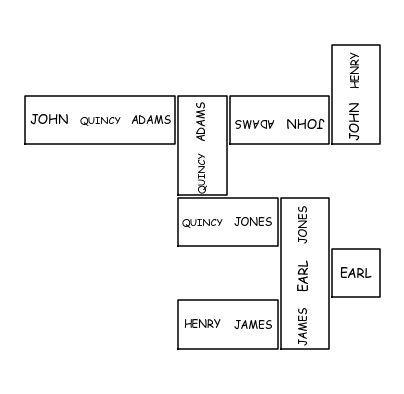

In [8]:
plot_board(board)

# All the Names

Now let's try all the names from the comic, courtesy of 
 [explainxkcd](http://www.explainxkcd.com/wiki/index.php/1970:_Name_Dominoes), with a few typos corrected. 

In [9]:
def define_tiles(text) -> list:
    "Create a list of tiles from the text containing names."
    return [Tile(name.strip().split()) for name in text.upper().split(',')]
           
xkcdtiles = define_tiles("""Christian Campbell, Neve Campbell, Joe McCarthy, Eugene McCarthy, 
  Gene Vincent, Gene Kelly, Kate Hudson, Rock Hudson, Gordon Brown, James Brown, John Brown, 
  John Howard, Columbo, Chris Columbus, Christopher Columbus, Naomi Campbell, Joseph Campbell, 
  Joseph Smith, Frank Vincent, John Kelly, Katherine Johnson, The Rock, Chris Rock, Chris Isaac, 
  James Newton Howard, John Wayne, Howard Stern, Howard Hunt, Chris Hughes, Naomi Watts, 
  Naomi Klein, Kevin Kline, Francis Bacon, Francis Drake, Lyndon Johnson, Oscar The Grouch, 
  Oscar Isaac, Isaac Hayes, Isaac Newton, Wayne Newton, Wayne Knight, Helen Hunt, Helen Hughes, 
  James Watt, James Watt, Kevin Costner, Kevin Bacon, Kevin Love, Lisa Frank, Frank Drake, Drake, 
  Oscar de_la Renta, Oscar de_la Hoya, Sean Hayes, Wallace Shawn, Wayne Howard, Wayne Brady, 
  James Brady, Tom Brady, Helen Thomas, Tom Hanks, Hank Aaron, Aaron Carter, Stephen James, 
  Will Smith, Kevin Smith, Kevin James, Garfield, James Garfield, Warren Buffett, Jimmy Buffett, 
  Warren Beatty, Elizabeth Warren, Earl Warren, Elizabeth Kolbert, Stephen Colbert, George Wallace,
  Charles Wallace, James Monroe, Marilyn Monroe, Hank Williams, William_C. Williams, Steve Harvey,
  Domino Harvey, Harvey Milk, James Saint James, Etta James, Jim Jones, James Earl Jones, 
  Charlie Parker, Ray Parker_Jr., Ray Charles, Charles Manson, Marilyn Manson, Robin Williams, 
  Billy_D. Williams, Will Wright, Fats Domino, Bill Clinton, Jimmy John, Tom Jones, Tommy John, 
  Quincy Jones, James Earl Ray, Man Ray, Rachel Ray, Ray Allen, Tim Allen, Tim Cook, Tim Howard, 
  Robin Wright, Wilbur Wright, Fatty Arbuckle, Fat Joe, George Clinton, John Kerry, 
  Kerry Washington, John Irving, John Quincy Adams, John Adams, Amy Adams, Aimee Mann, Super Man, 
  Bat Man, Ayn Rand, Lily Allen, Paul Allen, Ron Howard, Howard Hughes, Joe Kennedy, George Bush, 
  George Washington, Washington Irving, Martha Washington, Ma Rainey, Jack Ma, Super Grover, 
  Jack Black, Rand Paul, Paul Ryan, Paul Simon, Ron Paul, John Hughes, Langston Hughes, 
  John_F. Kennedy, Little Richard, Rich Little, Martha Stewart, Yo-Yo Ma, Ma Bell, 
  Grover Cleveland Alexander, Grover Cleveland, Jack White, Jack Ryan, Debby Ryan, Carly Simon, 
  Carly Hughes, Charles Evans Hughes, John Williams, Little John, Stuart Little, Potter Stewart, 
  Kristen Stewart, Kristen Bell, Bell Hooks, Alexander Graham Bell, Franklin Graham, 
  Lloyd Alexander, Meg White, Meg Ryan, Debbie Reynolds, John Reynolds, Carly Fiorina, 
  Grace Lee Boggs, Wade Boggs, William Safire, Prince William, Little Prince, Harry Potter, 
  James Potter, James Hook, James Dean, Aretha Franklin, Frank Lloyd Wright, Barry White, 
  Walter White, Walt Whitman, John Kelly, Grace Lee, Nancy Grace, Garnet, Prince, Prince Fielder, 
  Prince Harry, Harry Styles, John Dean, Benjamin Franklin, Harold Lloyd, Harold Ford, 
  Betty White, Meg Whitman, Christine Todd Whitman, Megyn Kelly, Grace Kelly, Grace Jones, 
  Jack Nicholson, Jack Ruby, Jack Russell, Harry Fielder, Harry Truman, Harry Jon Benjamin, 
  John Edward, Benjamin Harrison, Harrison Ford, Henry Ford, Betty Ford, Betty Friedan, 
  Chris Christie, Chris Pratt, Maggie Grace, Grace Hopper, Russell Crowe, Russ Smith, John Smith, 
  Justin Long, John Bel Edwards, John Candy, John Henry, Henry James, Bill James, Chris Cooper, 
  Chris Hemsworth, Chris Evans, Topher Grace, Van Morrison, Sheryl Crow, Sheryl Sandberg, 
  Cameron Crowe, Long John Silver, Olivia Newton John, Huey Long, John Edwards, Candy Crowley, 
  Aleister Crowley, James Fenimore Cooper, James Cook, Robert Frost, Bob Evans, Evan Taylor Jones,
  Van Jones, James Cameron, Cam Newton, Cameron Diaz, Huey Newton, Huey Lewis, John Lewis, 
  Jenny Lewis, Ryan Lewis, Burt Reynolds, Alistair Cooke, Alistair Cookie, Cokie Roberts, 
  John Roberts, Robert Johnson, Robert E._Lee, Tommy Lee, Tommy Lee Jones, Etta James,
  John Oliver, Ryan Reynolds, Alastair Reynolds""") 

len(xkcdtiles)

271

In [10]:
random.sample(xkcdtiles, 12)

[('EVAN', 'TAYLOR', 'JONES'),
 ('JOHN', 'LEWIS'),
 ('RYAN', 'REYNOLDS'),
 ('RAY', 'PARKER_JR.'),
 ('FATS', 'DOMINO'),
 ('ARETHA', 'FRANKLIN'),
 ('CHRIS', 'PRATT'),
 ('HENRY', 'JAMES'),
 ('FAT', 'JOE'),
 ('TOMMY', 'JOHN'),
 ('JAMES', 'NEWTON', 'HOWARD'),
 ('BARRY', 'WHITE')]

# Approximate Matches

Two names in adjacent squares match if they are an exact match, like `'ADAMS'` and `'ADAMS'`, or if they are an **approximate match**, like `'AMY'` and `'AIMEE'`. To accomodate this, I will manually define a set of approximate matches (again courtesy of 
 [explainxkcd](http://www.explainxkcd.com/wiki/index.php/1970:_Name_Dominoes)) by making the global variable `synonyms` be a set of pairs of names that should match: `{('AMY', 'AIMEE'), ('COOK', 'COOKE'),...}`. I will also redefine the function `allowed` to say that synonyms are allowed.


In [11]:
def define_synonyms(text='', tiles=()) -> set: 
    """Build a set of {(A, B),...} pairs, meaning that A and B are synonyms."""
    synsets = [synset.strip().split('=') for synset in text.split(',')]
    return {(a, b) for syn in synsets for a in syn for b in syn}

synonyms = define_synonyms("""AMY=AIMEE, COOK=COOKE=COOKIE=COKIE, ALASTAIR=ALISTAIR=ALESTIER, 
  COLUMBO=COLUMBUS, SAFIRE=SAPPHIRE=GARNET, GARNET=RUBY, CHARLIE=CHARLES, SEAN=SHAWN,
  JIMMY=JIM=JAMES, MAN=MANN, JACK=JOHN=JON=JOHN_F., TOM=TOMMY=THOMAS, HOOK=HOOKS, 
  ROBERT=ROBERTS=BOB, CAM=CAMERON, OLIVER=OLIVIA, EDWARD=EDWARDS, RICH=RICHARD, MEG=MEGYN, 
  CHRIS=CHRISTOPHER=CHRISTINE=TOPHER, FAT=FATS=FATTY, WALT=WALTER, HANK=HANKS, CROW=CROWE, 
  COLBERT=KOLBERT, LEE=E._LEE, KLINE=KLEIN, JOE=JOSEPH, GENE=EUGENE, KATE=KATHERINE, 
  FRANK=FRANCIS=FRANKLIN, WATT=WATTS, STEVE=STEPHEN, DEBBY=DEBBIE, STUART=STEWART, 
  WILL=WILLIAM=WILLIAMS=BILLY=BILLY_D.=WILLIAM_C., RUSS=RUSSELL, EVAN=EVANS""")

def allowed(name, nbr_contents) -> bool: 
    """A name is allowed next to an empty square, a square off the board, an exact match, or a synonym."""
    return nbr_contents in (name, empty, off) or (name, nbr_contents) in synonyms

# Final Result (after Multiple Tries)

The program sometimes gets stuck after placing relatively few tiles. I could modify the program to *back up* in this case, but it will be easier to just *give up* and restart with an empty board. I can restart multiple times, and accept the best board (the one on which the most names were placed):

152 tiles placed on 312 squares
CPU times: user 3min 56s, sys: 940 ms, total: 3min 57s
Wall time: 3min 59s


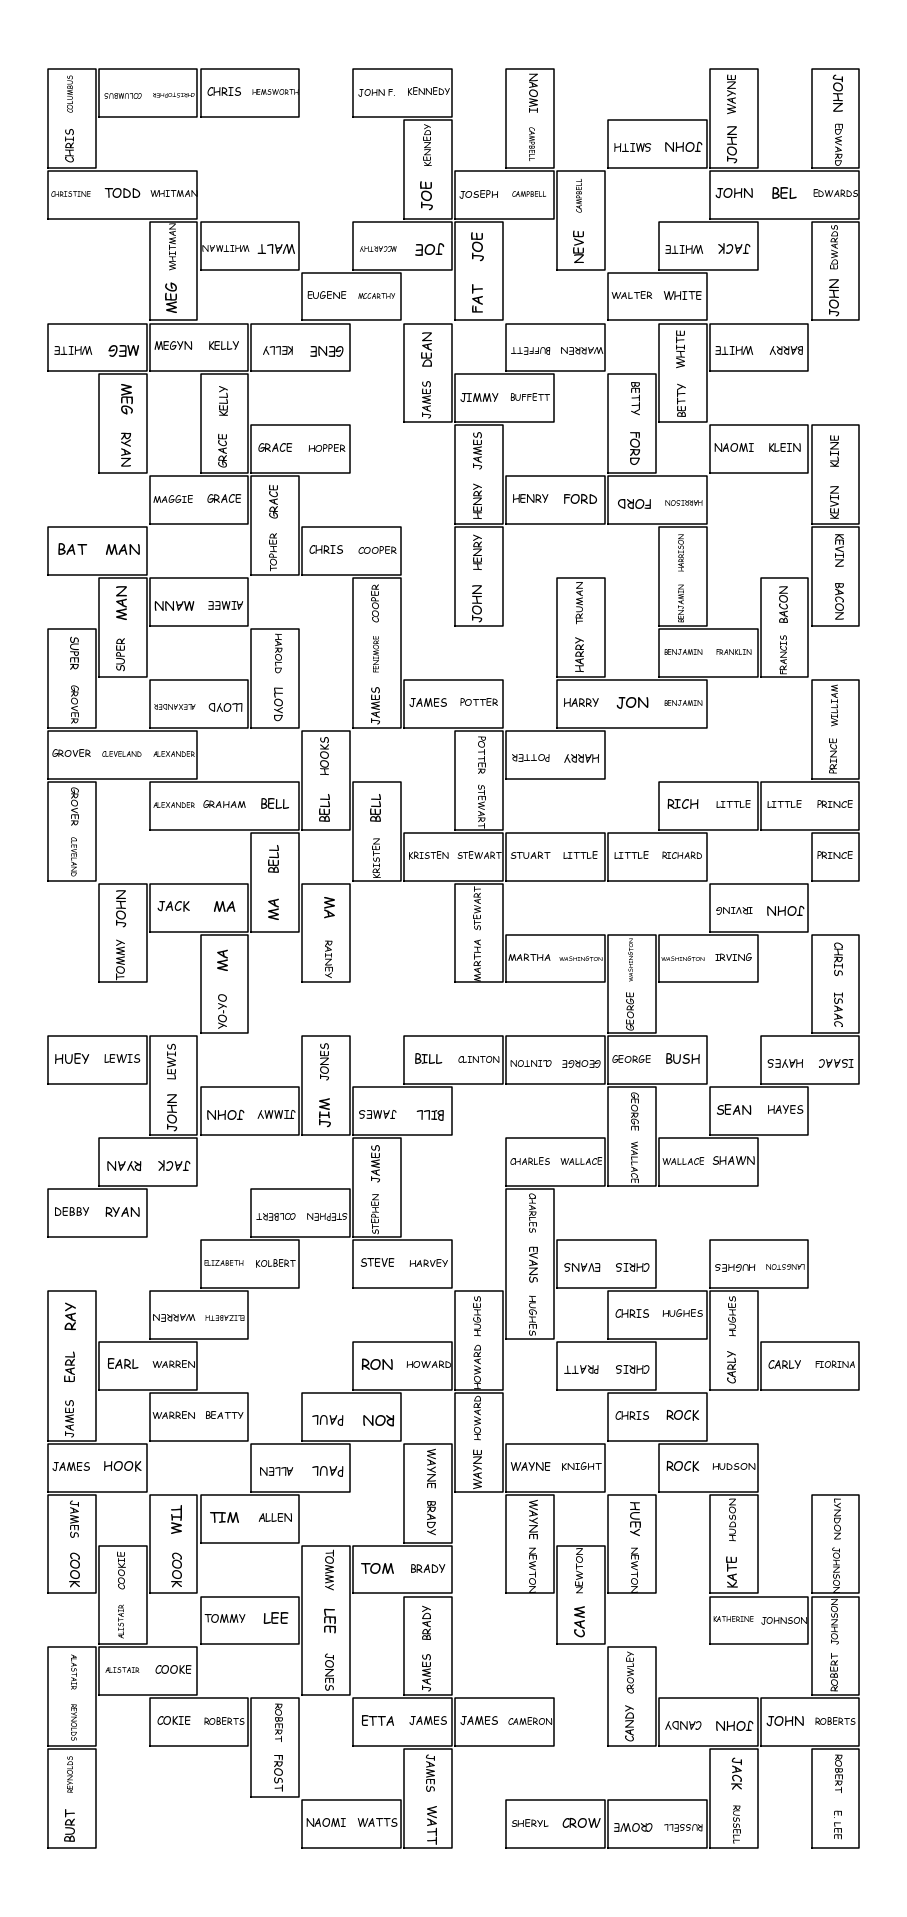

In [12]:
%time plot_board(max((place_tiles(xkcdtiles) for _ in range(100)), key=len))

*Note:* I used a 16×35 square board while the xkcd comic used 27×35, because if I tried to fit 27 squares across then each tile would be smaller, and many names would overflow the sides of the dominoes too much. Here is the [original xkcd comic](https://xkcd.com/1970/):

![](https://imgs.xkcd.com/comics/name_dominoes_2x.png)

# What's Next?

I'm happy with the results, but here are some ideas for improvements, if you want something to work on:
- See if a different strategy can fit more tiles on the board. 
  - Backtracking? 
  - Being smarter about which frontier square to try next? 
  - Being smarter about which tile to place on that frontier square?
- Make the dominoes black with white letters? Ever-so-slightly round the corners?
- Download a bunch of names from Wikipedia and fill a 200 × 300 board, then laser cut tham and hang them on your wall?
- If you like xkcd try [regex golf](https://github.com/norvig/pytudes/blob/master/ipynb/xkcd1313.ipynb), and [part 2](https://github.com/norvig/pytudes/blob/master/ipynb/xkcd1313-part2.ipynb).
- What do you want to do?
